# Data preprocessing

In [3]:
import csv
import os
import shutil
import time
from pydub import AudioSegment
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio
import librosa
import soundfile as sf

D:\University\AccentedASR\venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Extracting relevant files

Before working on the data, it is necessary to ensure relevant data is avaialble. To train data to work better with South asian accents it is important we only get audio clips with SOuth asian accents.

Svarah is collected to be specific to India so that does not need to be sorted.

Common Voice contains data from people with diverse backgrounds. For this project, we only need data with accents tags of India and Pakistan. Voice clips that originate from South Asia are labelled as India and South Asia (India, Pakistan, Sri Lanka). For our purpose these are the only audio clips we will use. Further, to avoid empty or faulty files, only audio clips about India and South Asia mentioned in the validated  TSV file will be used. Below code extracts any audio clip of which teh label contains "pak" or "ind". Based on how Common Voice is done, this will include voice clips fro people of Sri Linkan origin as well.

In [ ]:
VALIDATED_FILE_PATH = "D:/University/cv-corpus/en/validated.tsv"
TARGET_ACCENT_PAK = "pak"
TARGET_ACCENT_IND = "ind"


# TODO: new validated file that includes only the names of the relevant pakistani and indian files and info related to them

with open(VALIDATED_FILE_PATH, newline='', encoding='utf-8') as file:
    # Create a CSV reader object, specifying the delimiter as a tab character
    reader = csv.reader(file, delimiter='\t')

    # Used to store names of all the clips that are indian or pakistani
    clipFileNames = set();
    count = 0
    # Iterate through each row in the TSV file
    for row in reader:

        # Check if the value in the 'accents' column matches the target value for the accents
        # 'accents' column is the 8th column (index 7)
        if (TARGET_ACCENT_PAK.lower() in row[7].lower()) or \
                (TARGET_ACCENT_IND.lower() in row[7].lower()):
            # Add the clip name to array (Column 2, index 1) if match is successful
            clipFileNames.add(row[1].lower())
            count = count + 1
    print(f"{count} number of files in Validated tsv")

print("\n\n")
# Define the directory path for all clips
sourceDirPath = "D:/University/cv-corpus/en/clips/"
# Get a list of all files in the directory
filesInDir = os.listdir(sourceDirPath)

# path to store data in, if doesn't exist then make one
destDirPath = "D:/University/cv-corpus/en/ind_pak_clips/"
if not os.path.exists(destDirPath):
    os.makedirs(destDirPath)

count = 0

# Find and copy clips that are pakistani or Indian
for clipName in filesInDir:
    if (clipName.lower() in clipFileNames):
        # file path of the source directory copy clips from
        VALIDATED_FILE_PATH = os.path.join(sourceDirPath + clipName)
        # directory to paste file into
        destPath = os.path.join(destDirPath + clipName)

        # when files are found, increase count
        count = count + 1
        #Copy file to a new folder: ind_pak_data
        shutil.copy2(VALIDATED_FILE_PATH, destPath)

    if (count % 1000 == 0):
        print(f"Number of files done: {count}")

print(f"Copied {count} number of files")



## Finding length of all the relevant data we can use

Once we have the relevant audio clips, we might want to know the length of total audio we have. There is a clip_duration.tsv file provided which mentions the length of all the audio clips. We can check the name of every audio we have in the clip_duration.tsv file and add up the values to calculate the total time.

In [1]:
DURATION_FILE = "D:/University/cv-corpus/en/clip_durations.tsv"
durationDict = {}

with open(DURATION_FILE, newline='', encoding='utf-8') as file:

    # Create a CSV reader object, specifying the delimiter as a tab character
    reader = csv.reader(file, delimiter='\t')
    next(reader)

    # Used to store names of all the clips that are indian or pakistani
    clipFileNames = set();

    # Iterate through each row in the TSV file to get all the names
    for row in reader:
        durationDict[row[0]] = int(row[1])

# path to the source with all the audio clips.
sourceDirPath = "D:/University/cv-corpus/en/ind_pak_clips/"
# Get a list of all files in the directory
filesInDir = os.listdir(sourceDirPath)

count = 0
msTotalTime = 0
for file in filesInDir:
    msTotalTime = msTotalTime + durationDict[file]
    count += 1

# default is in ms which we dont want
sTotalTime = msTotalTime / 1000 # seconds
mTotalTime = sTotalTime / 60 # minutes
hTotalTime = mTotalTime / 60 # hours

# Print the results
print(f"""
Number of files: {count}
ms: {msTotalTime:.0f}
sec: {sTotalTime:.0f}
mins: {mTotalTime:.0f}
hrs: {hTotalTime:.0f}
""")


FileNotFoundError: [Errno 2] No such file or directory: 'D:/University/cv-corpus/en/clip_durations.tsv'

## File Format

As the data we have in Svarah and Common Voice currently is in different formats, it is worth changing one fo them so botht he audio clips are of the same format. Below code chanegs all teh Common Vocie audio clips from mp3 to wav, same as Svarah.


In [ ]:
def convert_file(file, srcDirPath, destDirPath):
    if file.endswith(".mp3"):
        outFile = os.path.join(destDirPath, os.path.splitext(file)[0] + ".wav")
        audio = AudioSegment.from_file(os.path.join(srcDirPath, file))
        audio.set_frame_rate(16000).export(outFile, format="wav")
        # return f"Converted {file} to {outFile}"


def make_mp3(srcDirPath, destDirPath):
    files = os.listdir(srcDirPath)

    # Create destination directory if it doesn't exist
    if not os.path.exists(destDirPath):
        os.makedirs(destDirPath)

    # Using ProcessPoolExecutor to parallelize the task
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(convert_file, file, srcDirPath, destDirPath) for file in files]
        count = 0
        for future in concurrent.futures.as_completed(futures):
            future.result()
            count += 1
            if count % 1000 == 0:
                print(f"count: {count}")



start_time = time.perf_counter()

wrongFormatDir = "D:/University/Data/cv-corpus/en/ind_pak_clips_mp3"
rightFormatDir = "D:/University/Data/cv-corpus/en/ind_pak_clips_wav/"

# wrongFormatDir = "D:/University/Data/sample/mp3"
# rightFormatDir = "D:/University/Data/sample/wav"
make_mp3(wrongFormatDir, rightFormatDir)

end_time = time.perf_counter()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"The code block took {elapsed_time} seconds to run.")

## Zero Crossing Rate

To reduce computation time, we can reduce total audio length by removing gaps in audio. We will use Zero Crossing rate (ZCR) to do this. ZCR is besically a measure of how often an audio signal changes from positive to negative. During silences with minor noise, the ZCR rate will be high compared to low times when someone is speaking.

The code below for now is only for one file

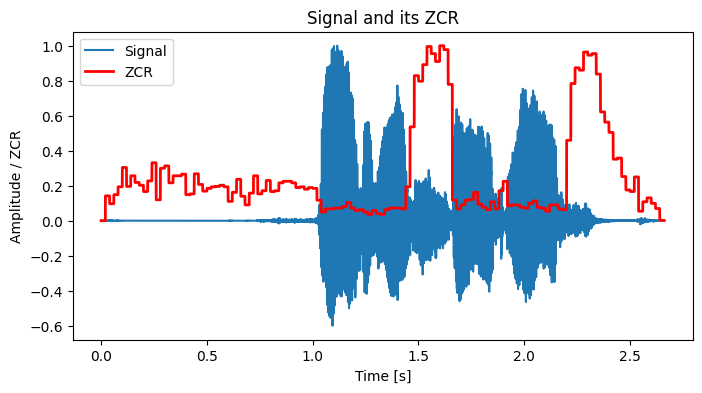

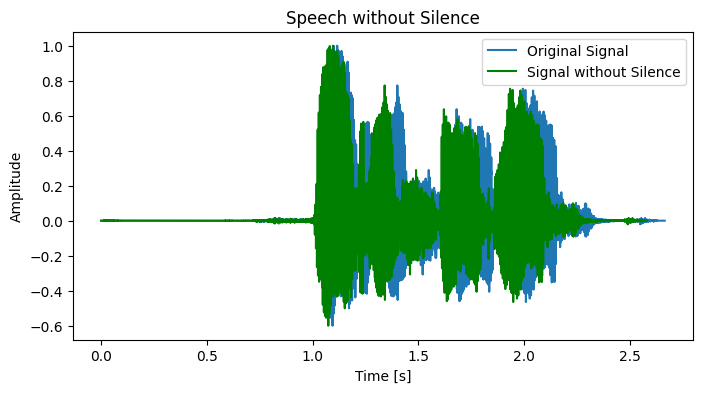

Original Audio 



After removing based on ZCR 



Modified audio saved to D:/University/Data/sample/zcr/common_voice_en_220787.wav


In [10]:
def framing(signal, frameDuration, sampleRate):
    frameLen = int(frameDuration * sampleRate)
    frames = []
    for start in range(0, len(signal), frameLen):
        frame = signal[start:start + frameLen]
        if len(frame) == frameLen:
            frames.append(frame)
    return np.array(frames)

def calculateZcr(frames):
    zcr = np.zeros(frames.shape[0])
    for i, frame in enumerate(frames):
        # Count the zero crossings
        zcr[i] = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return zcr

# Read WAV file
# TODO: no hardcoding singular file paths
inputAudioFile = "D:/University/Data/sample/wav/common_voice_en_220787.wav"
sampleRate, signal = wavfile.read(inputAudioFile)
# Normalize the signal
signal = signal / np.abs(np.max(signal)).astype(float)

# Do framing
frameDuration = 0.020  # 20ms per frame
frames = framing(signal, frameDuration, sampleRate)

# Calculate ZCR for all frames
zcrValues = calculateZcr(frames)

# Calculate rate and normalize
zcrRate = zcrValues / frames.shape[1]
zcrRateNormalized = zcrRate / np.max(zcrRate)

# Create a ZCR waveform for plotting
zcrWave = np.repeat(zcrRateNormalized, frames.shape[1])

# Plot the ZCR with Signal
t = np.linspace(0, len(signal) / sampleRate, len(signal))
t1 = np.linspace(0, len(zcrWave) / sampleRate, len(zcrWave))

plt.figure(figsize=(8, 4))
plt.plot(t, signal, label='Signal')
plt.plot(t1, zcrWave, 'r', linewidth=2, label='ZCR')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude / ZCR')
plt.legend()
plt.title('Signal and its ZCR')
plt.show()

# Silence Removal
silenceThreshold = 0.04

nonSilenceIndices = zcrRateNormalized > silenceThreshold
framesWithoutSilence = frames[nonSilenceIndices]

# Reconstruct signal from frames without silence
dataReconstructed = np.hstack(framesWithoutSilence)
# calculate time in seconds properly
tReconstructed = np.arange(len(dataReconstructed)) / sampleRate


plt.figure(figsize=(8, 4))
plt.plot(t, signal, label='Original Signal')
plt.plot(tReconstructed, dataReconstructed, 'g', label='Signal without Silence')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Speech without Silence')
plt.show()

# Save the modified signal to a WAV file
# TODO: no hard coding singular file paths
outputAudioFilePath = 'D:/University/Data/sample/zcr/common_voice_en_220787.wav'
wavfile.write(outputAudioFilePath, sampleRate, dataReconstructed.astype(np.float32))

print(f"Original Audio \n")
display(Audio(inputAudioFile))
print(f"After removing based on ZCR \n")
display(Audio(outputAudioFilePath))
print(f"Modified audio saved to {outputAudioFilePath}")


## Removing leading and trailing silence

Continuing from the last part, most of the audios have empty sound before and after speech. We cane easily remove by very low volume audios from the file. For this, we are taking the route of checking for the sound decibels.

For now, the below code only does it for one audio file.

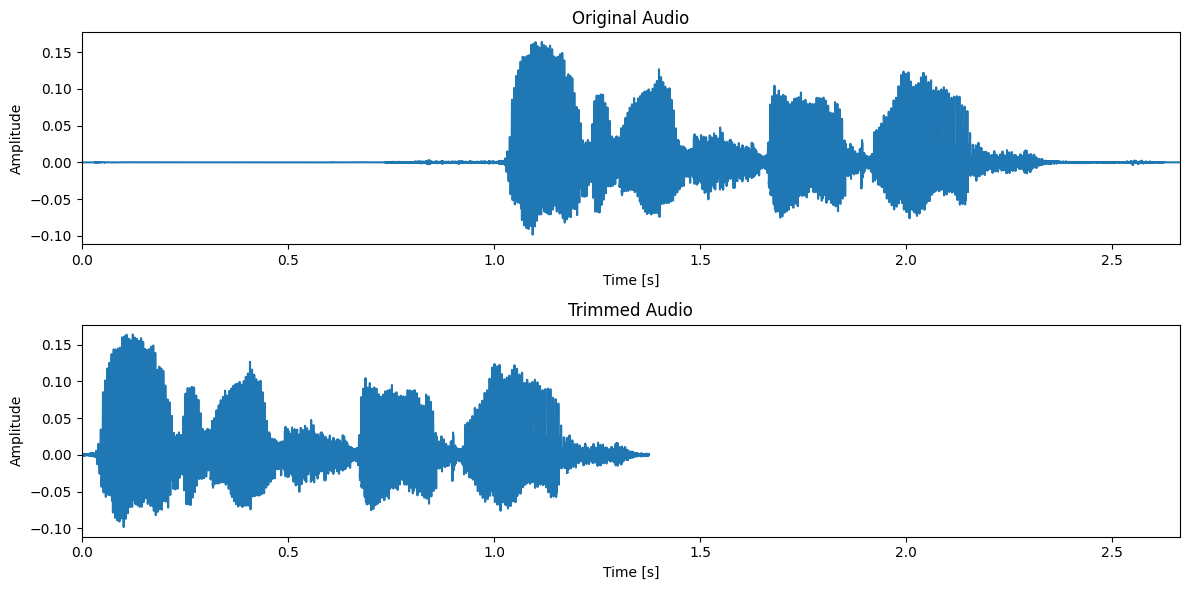

In [11]:
# Load audio file
audio, sr = librosa.load("D:/University/Data/sample/wav/common_voice_en_220787.wav", sr=None)

# Time axis for the original audio
tOriginal = np.linspace(0, len(audio) / sr, num=len(audio))


#Duration of the original audio
maxDuration = len(audio) / sr

# Trim silence
trimmedAudio, _ = librosa.effects.trim(audio, top_db=30)  # top_db is the threshold for silence

# Create a time axis for the trimmed audio
tTrimmed = np.linspace(0, len(trimmedAudio) / sr, num=len(trimmedAudio))

# Save the trimmed audio
sf.write("D:/University/Data/sample/trimmed/common_voice_en_220787.wav", trimmedAudio, sr)

# Plot the original and trimmed audio signals
plt.figure(figsize=(12, 6))

# Plot original audio
plt.subplot(2, 1, 1)
plt.plot(tOriginal, audio)
plt.title('Original Audio')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim([0, maxDuration])  # Ensure the x-axis is the same for both plots


# Plot trimmed audio
plt.subplot(2, 1, 2)
plt.plot(tTrimmed, trimmedAudio)
plt.title('Trimmed Audio')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim([0, maxDuration])  # Ensure the x-axis is the same for both plots


plt.tight_layout()
plt.show()
